In [2]:
import scipy.io
import numpy as np 
import pdb
import torch
from common.data_normalization import *
from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
from sys import argv
from process_params import *
# argv lr heldout nntype seed dropout nodes epoch p4p true_load nm ne suffix(avi_,v1_,...)
dm='nm'
dm='wm'
train_mode='ne'
suffix='v1.6_'
suffix='v0.1_'
data_mode=data_mode[:-2]+dm

Rolling out 242test trajectories.


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(242, 4)


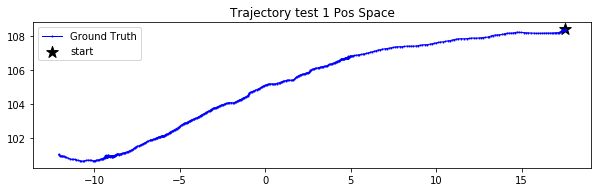

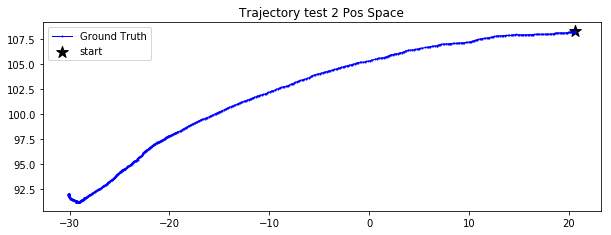

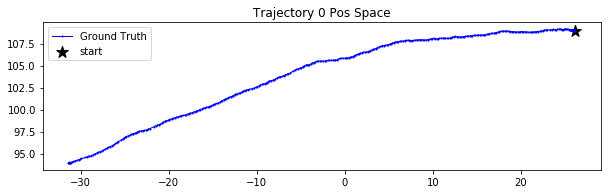

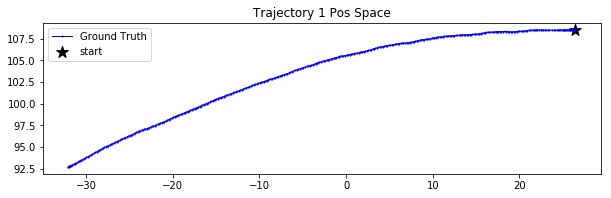

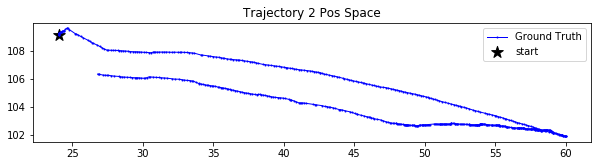

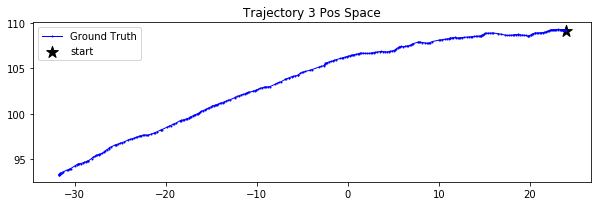

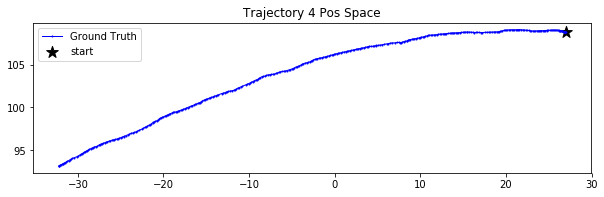

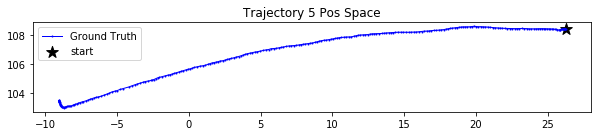

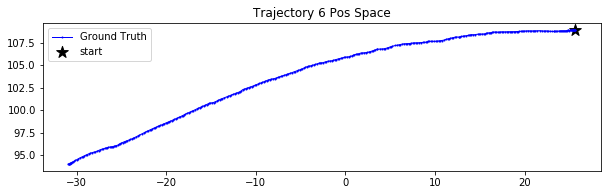

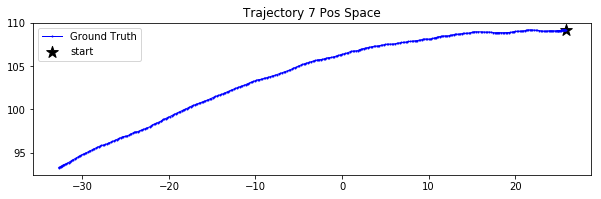

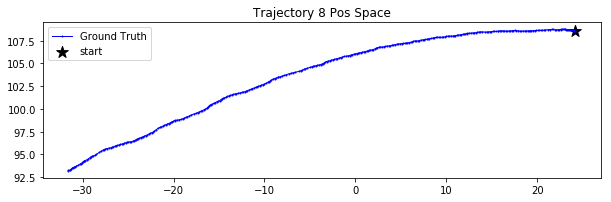

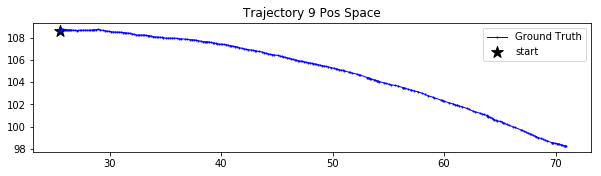

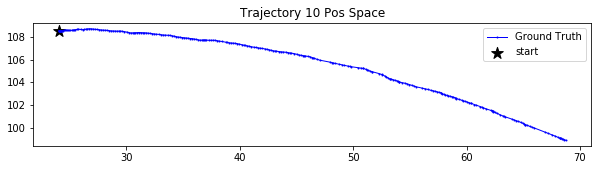

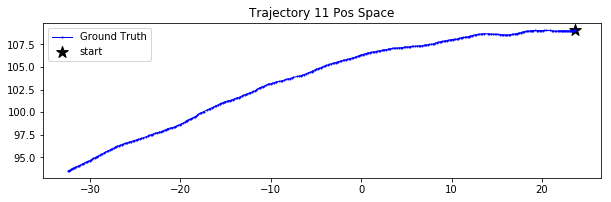

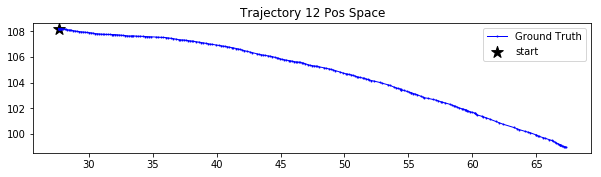

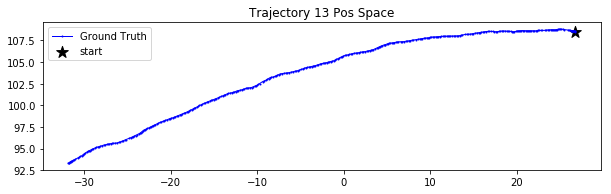

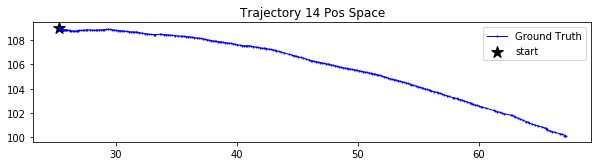

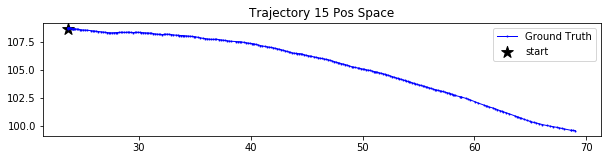

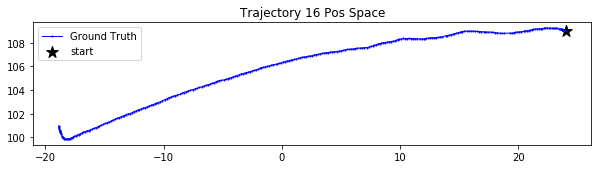

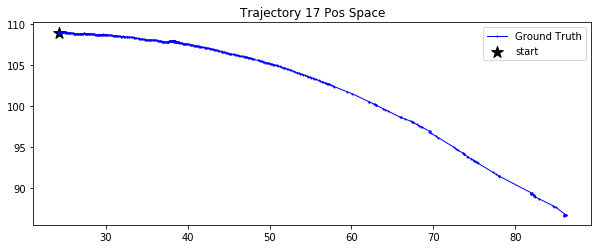

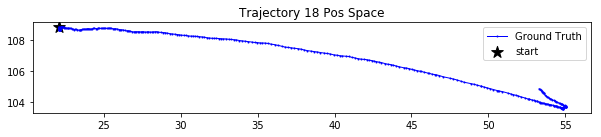

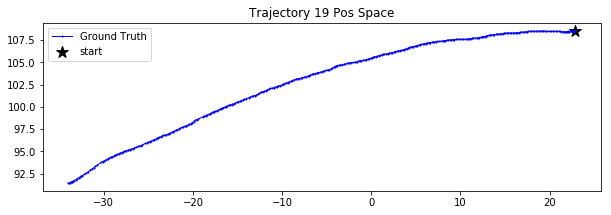

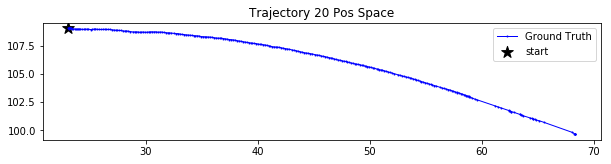

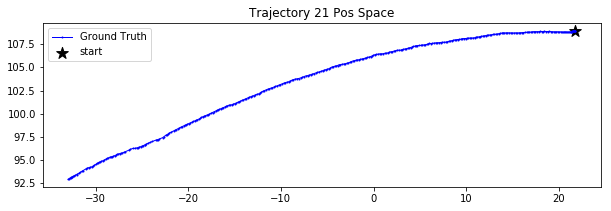

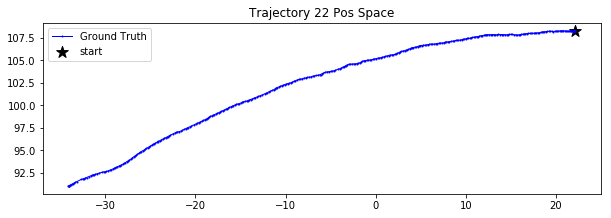

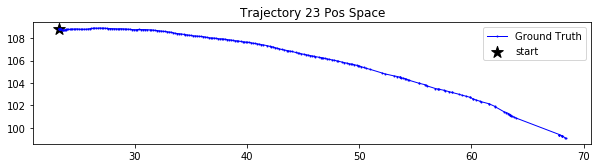

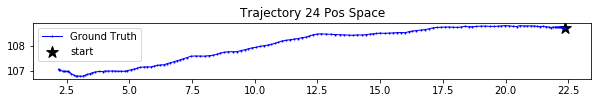

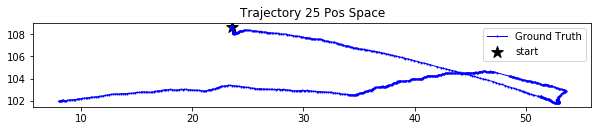

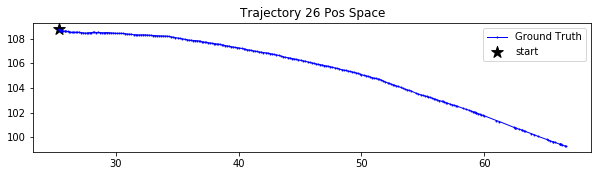

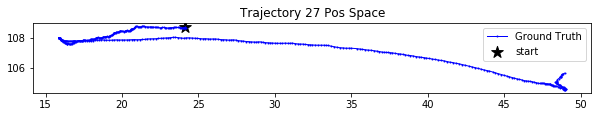

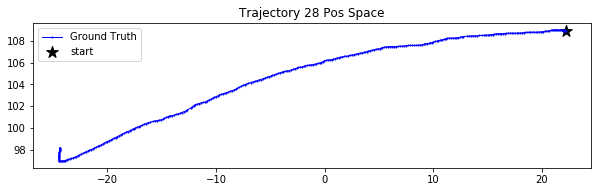

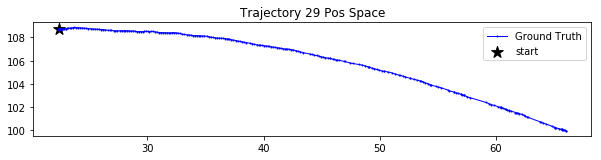

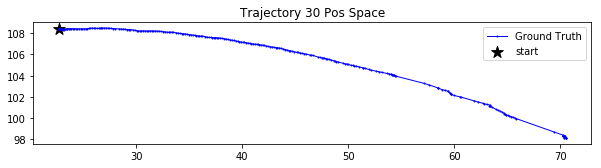

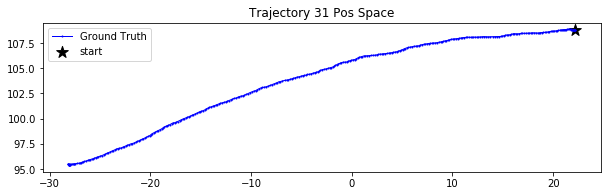

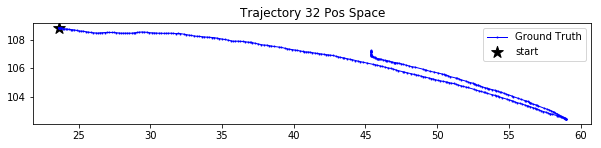

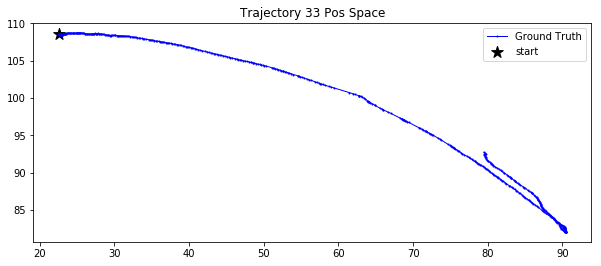

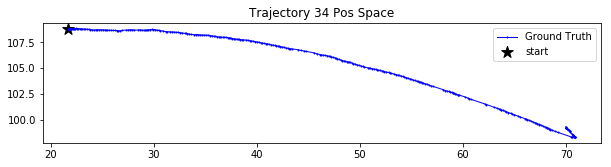

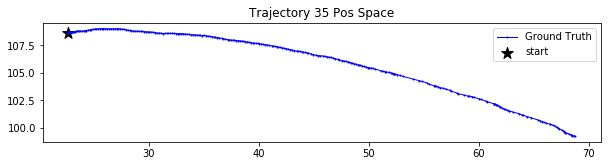

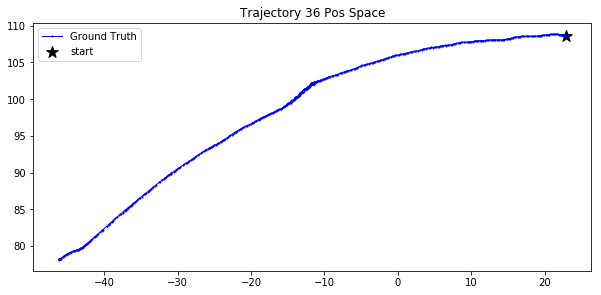

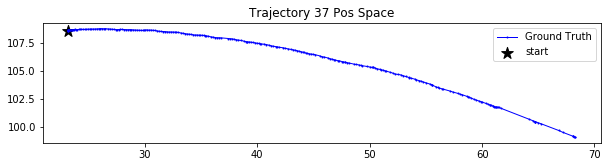

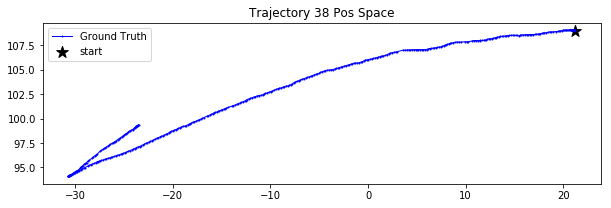

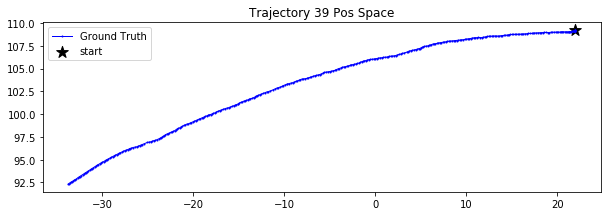

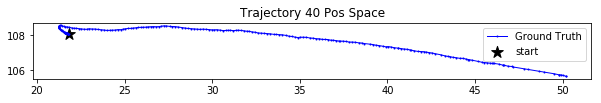

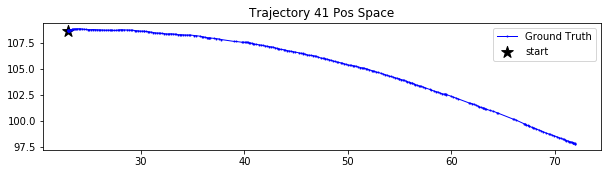

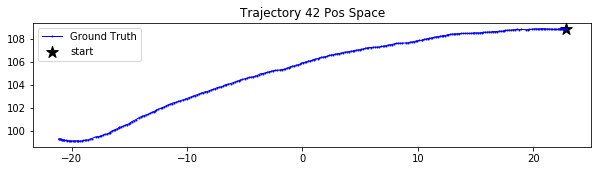

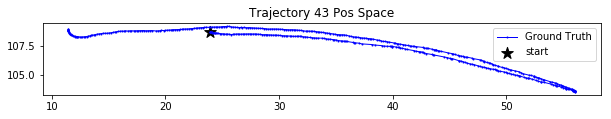

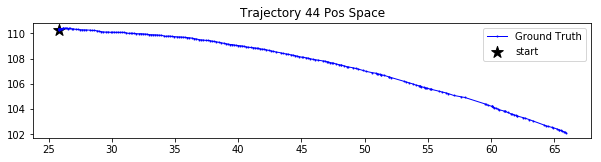

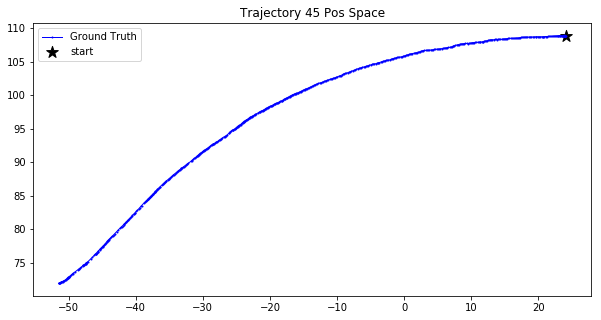

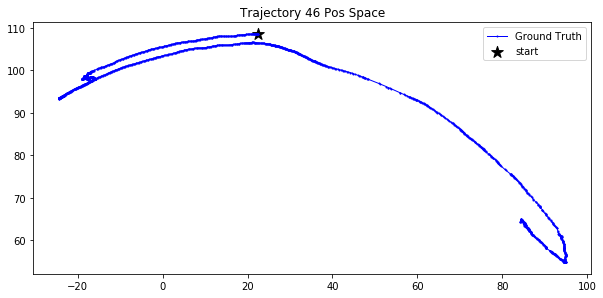

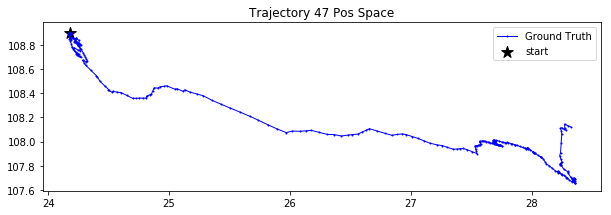

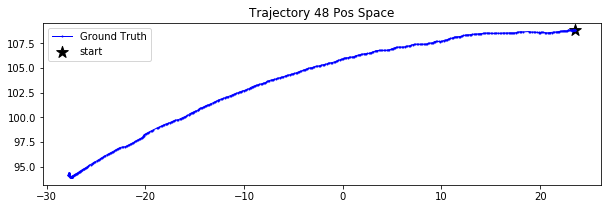

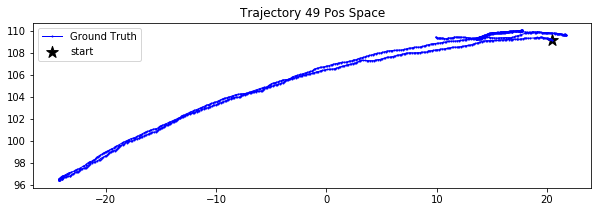

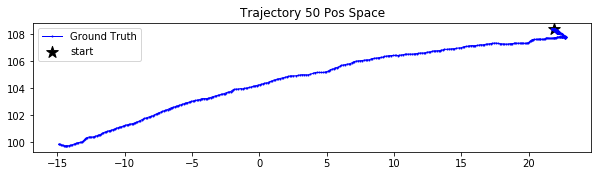

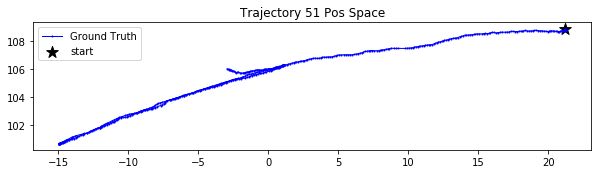

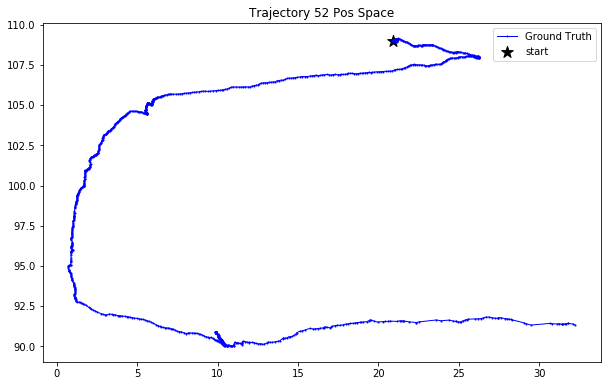

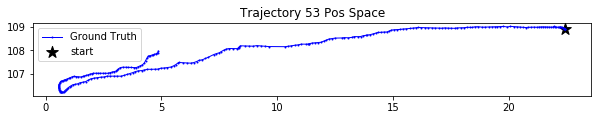

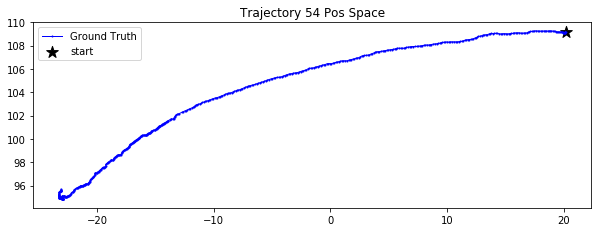

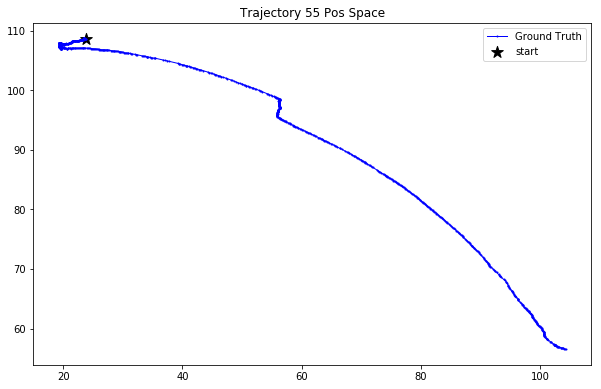

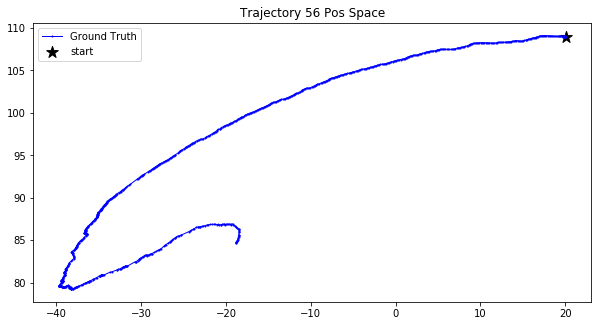

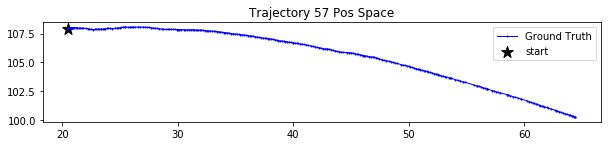

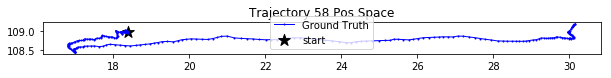

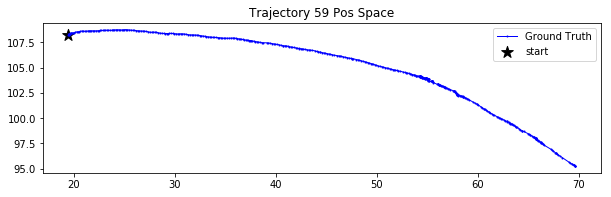

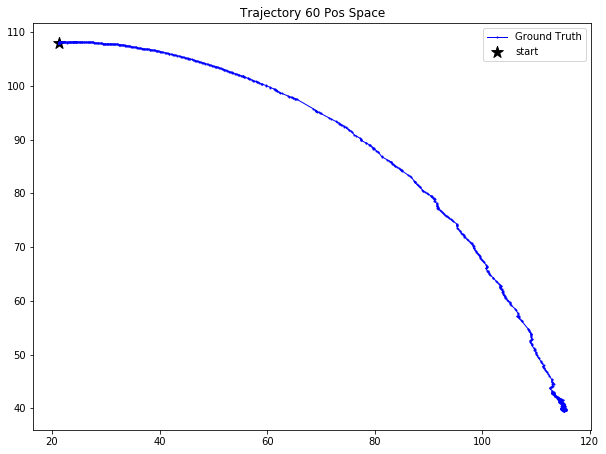

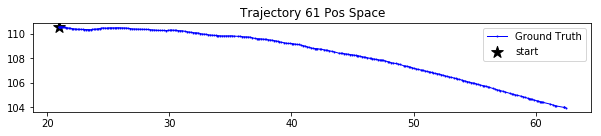

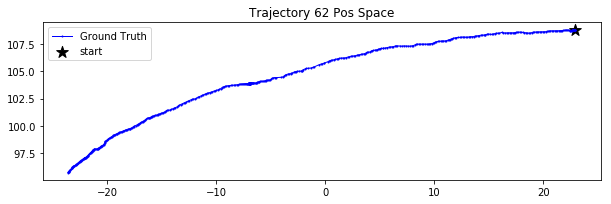

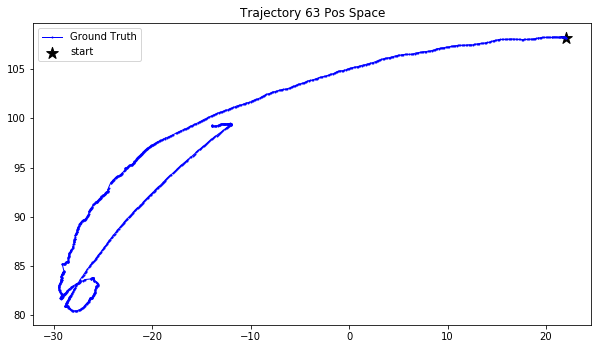

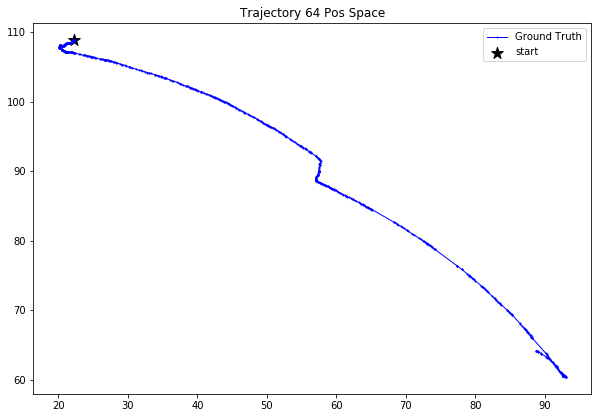

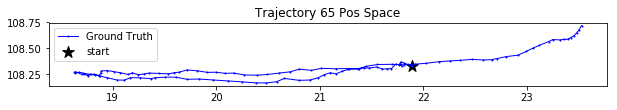

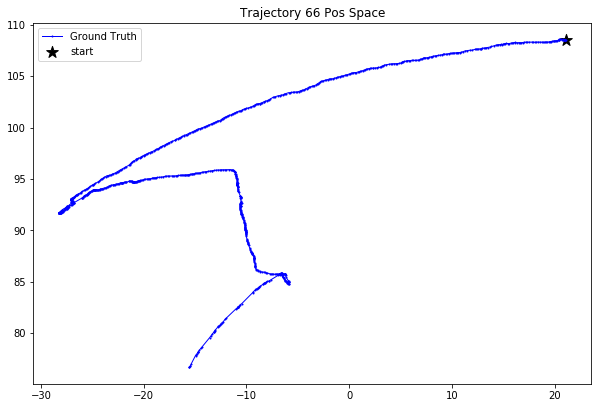

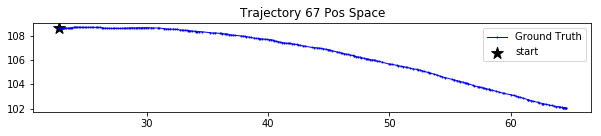

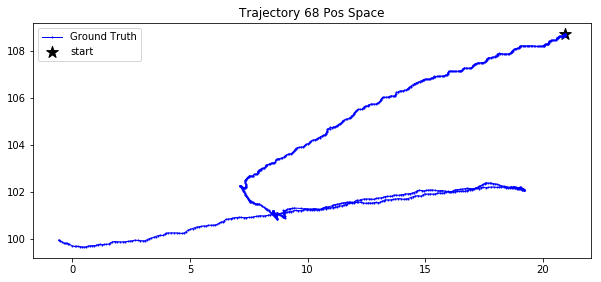

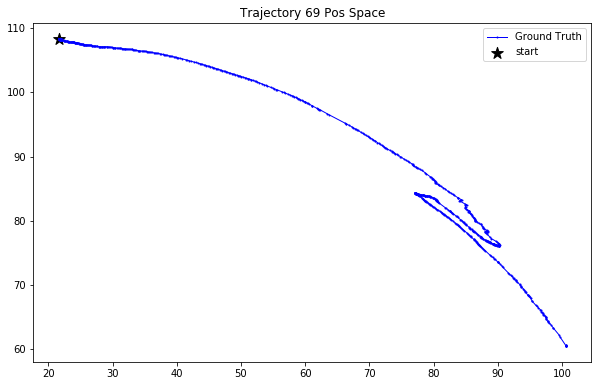

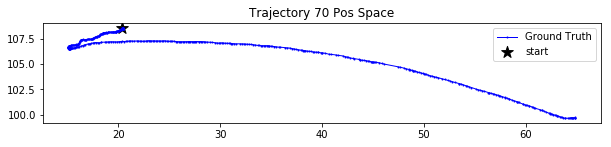

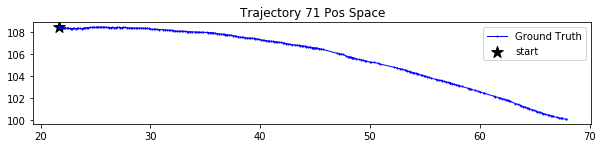

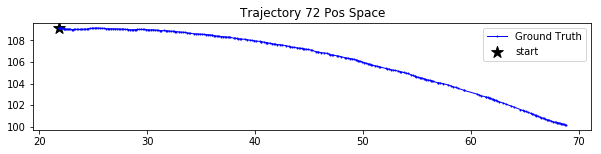

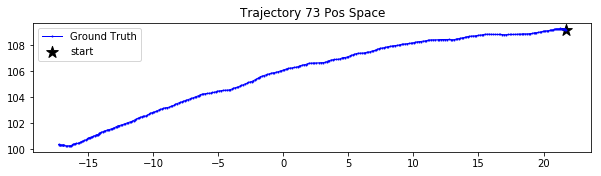

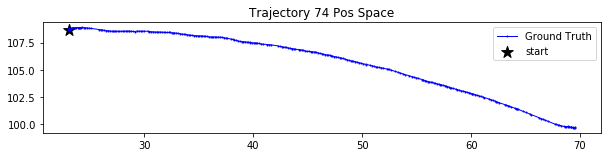

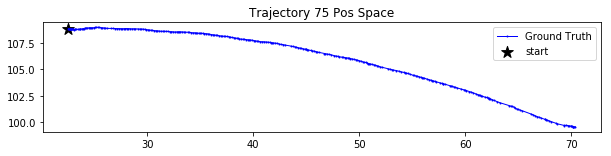

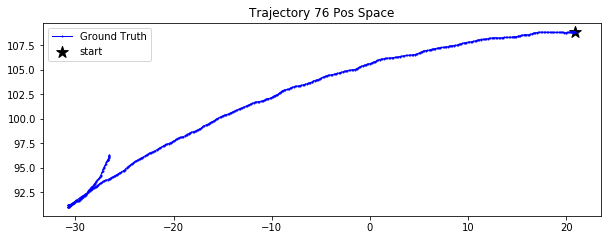

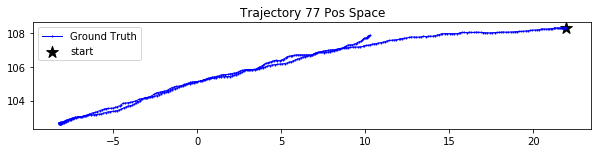

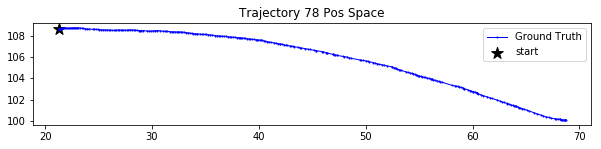

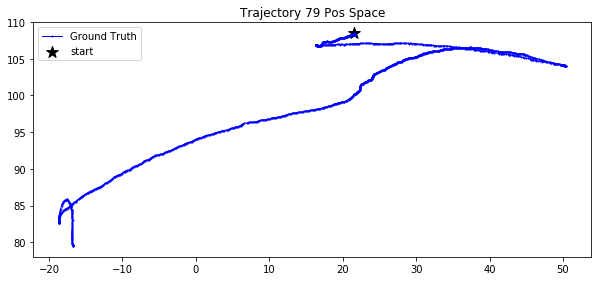

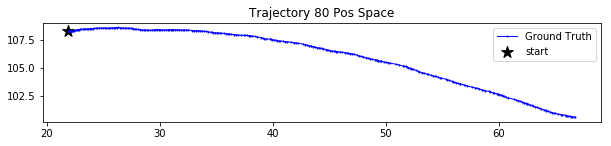

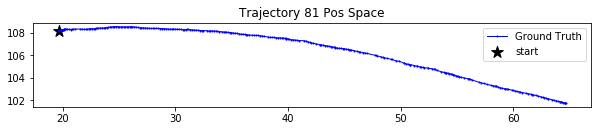

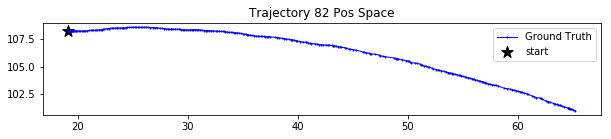

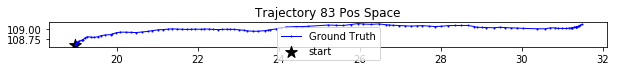

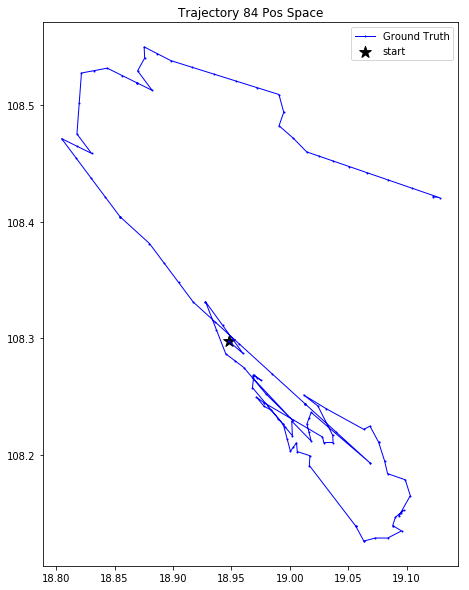

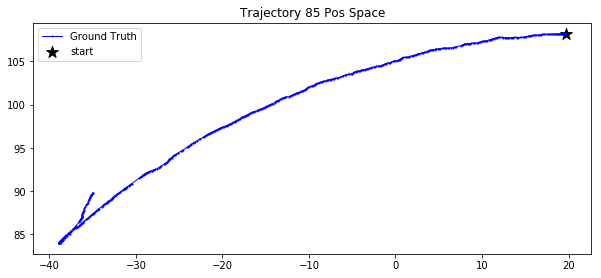

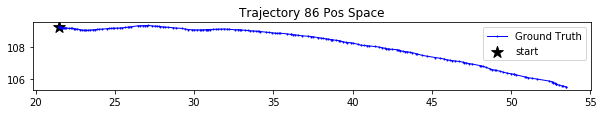

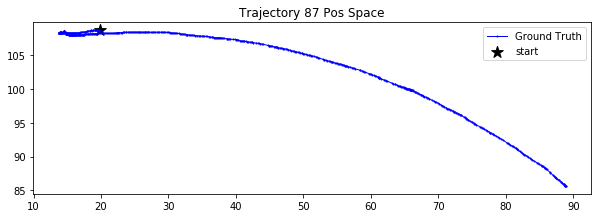

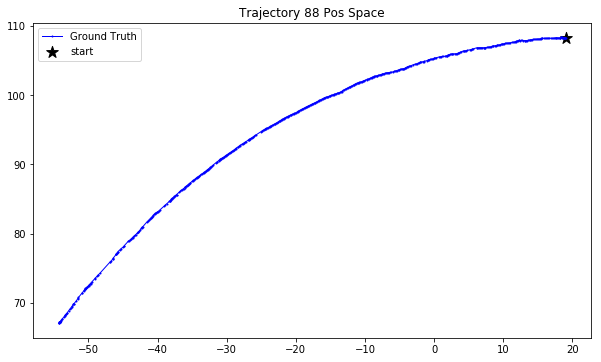

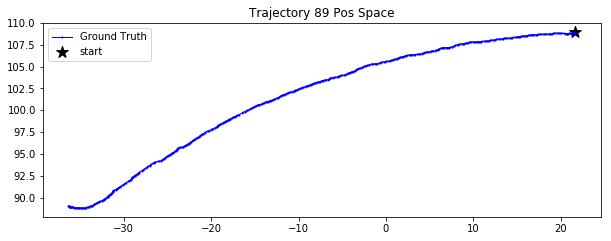

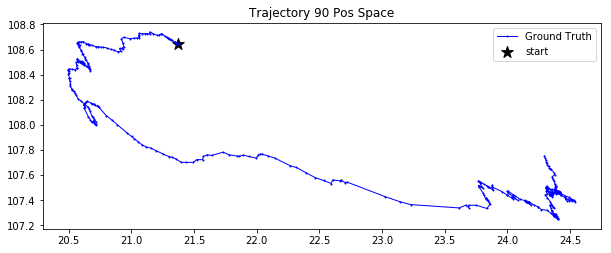

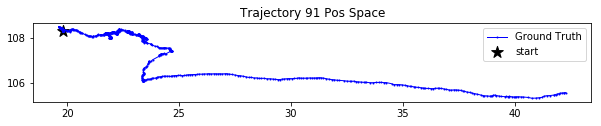

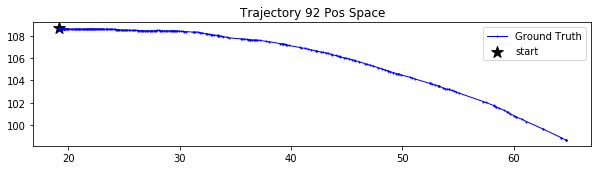

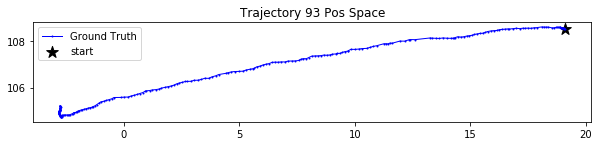

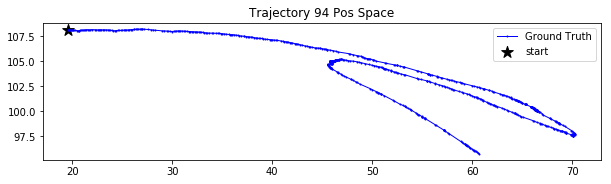

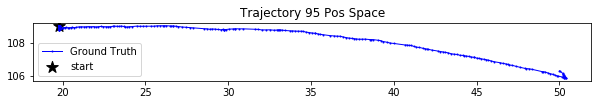

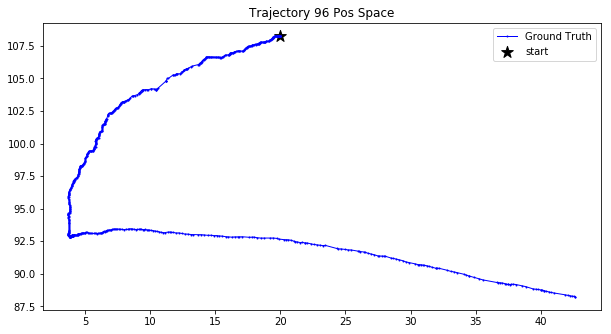

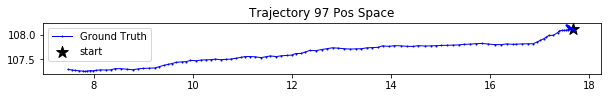

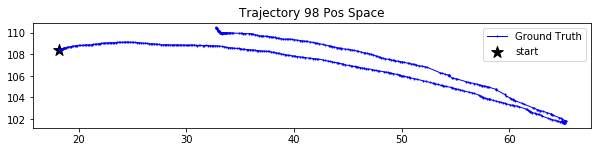

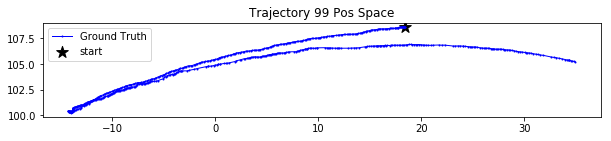

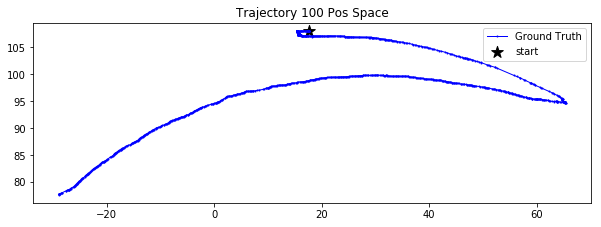

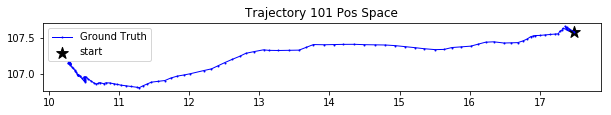

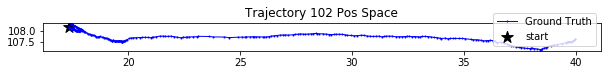

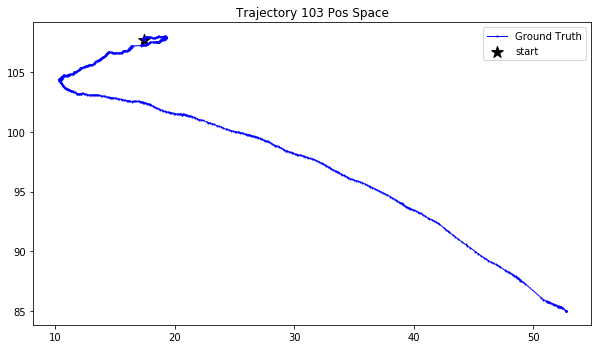

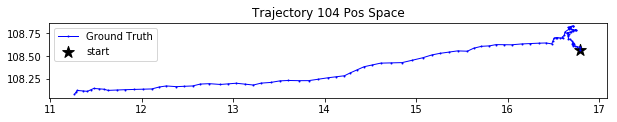

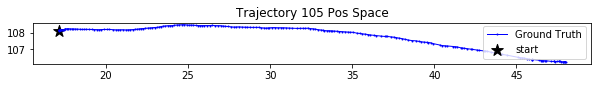

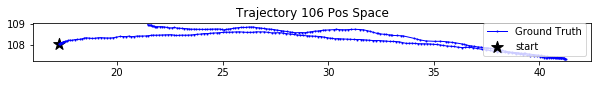

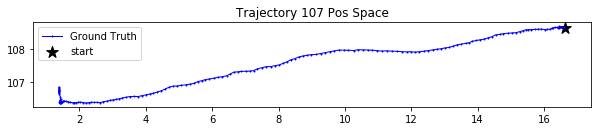

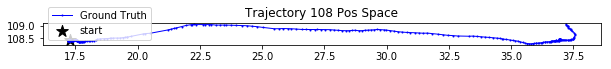

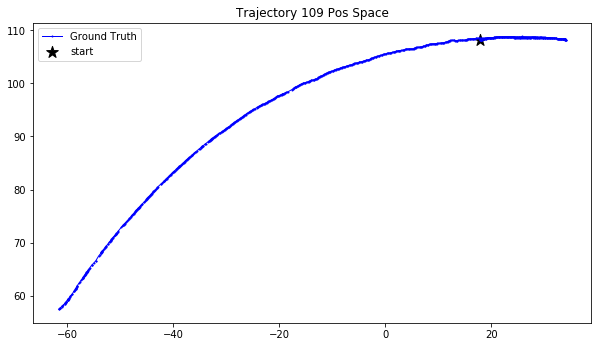

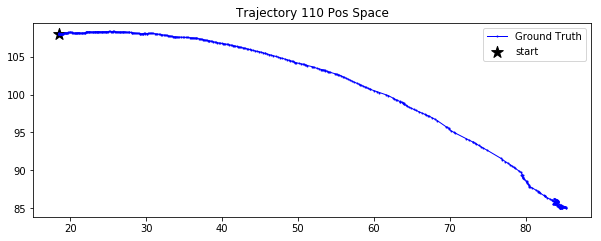

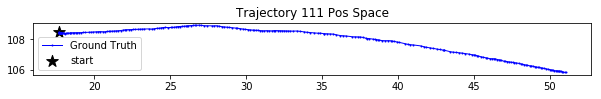

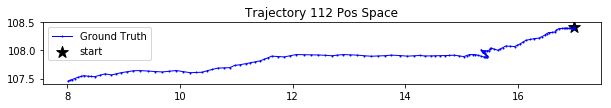

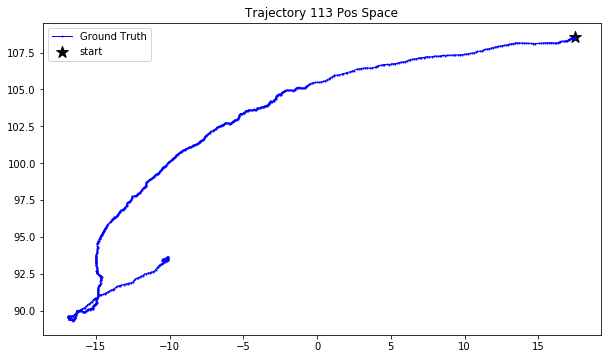

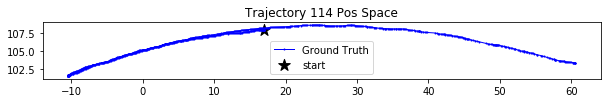

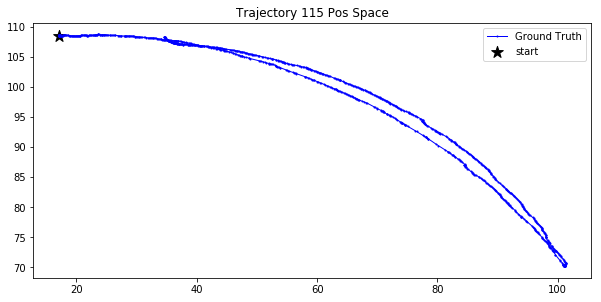

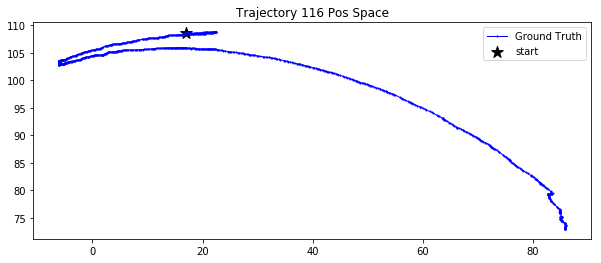

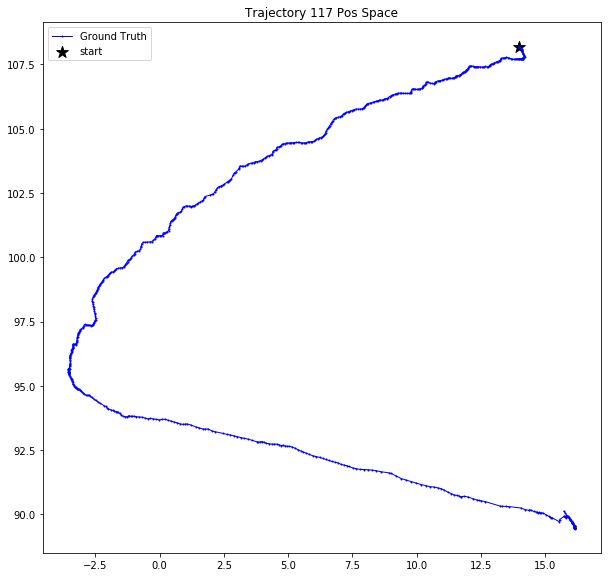

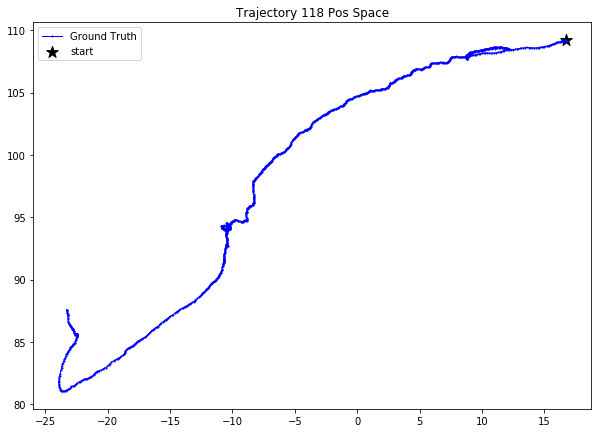

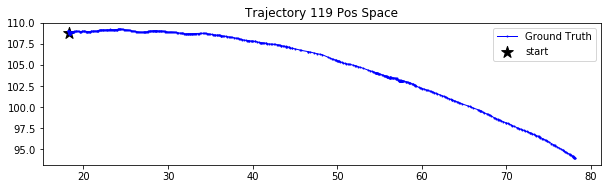

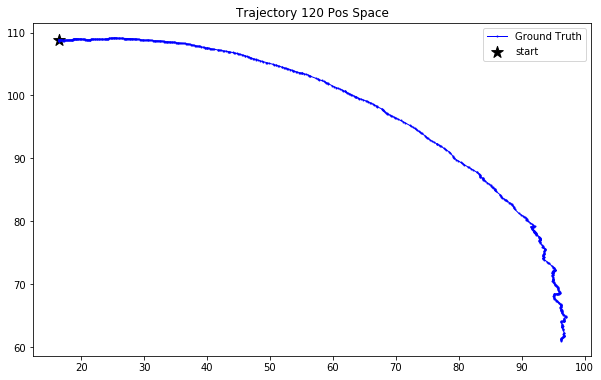

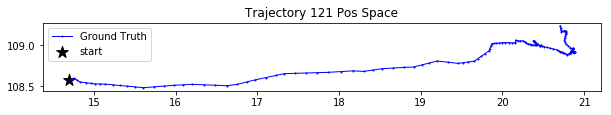

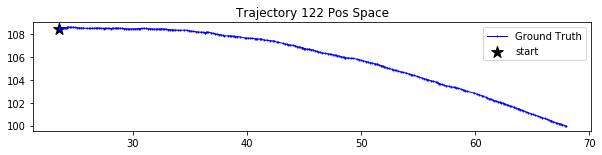

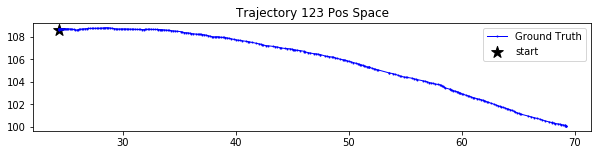

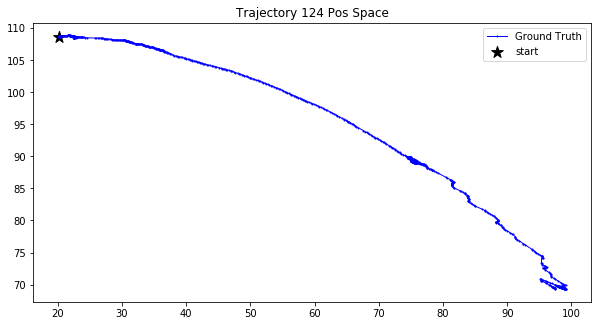

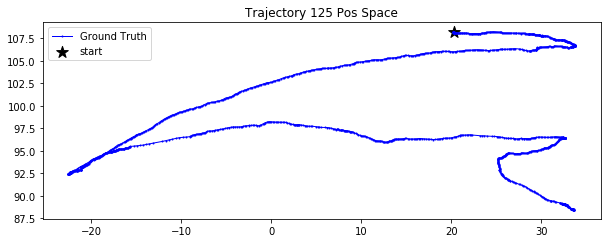

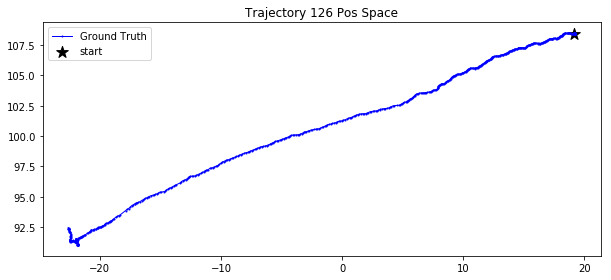

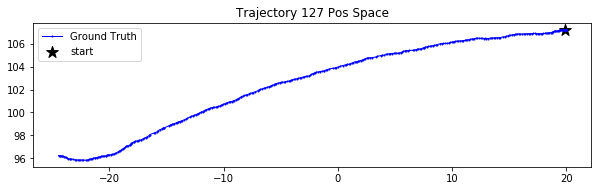

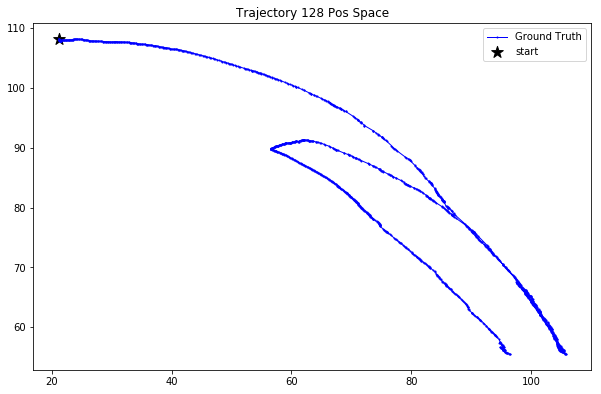

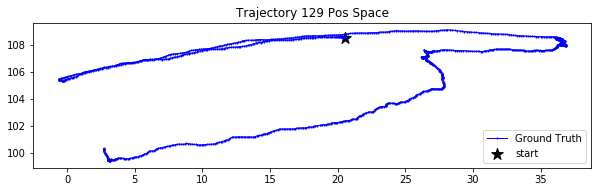

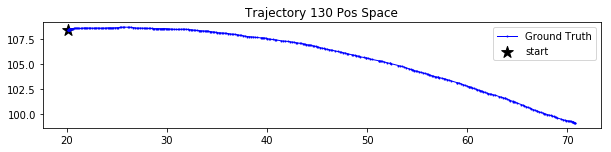

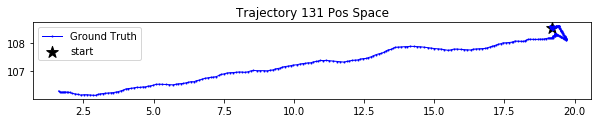

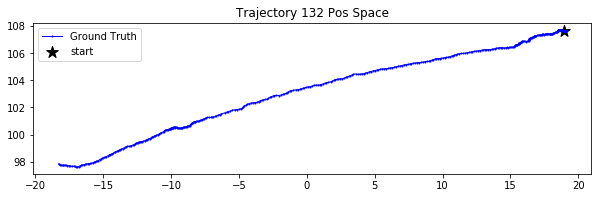

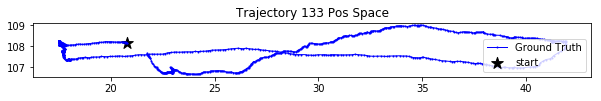

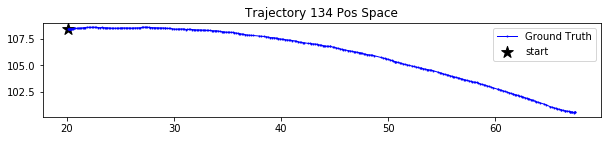

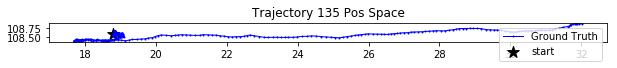

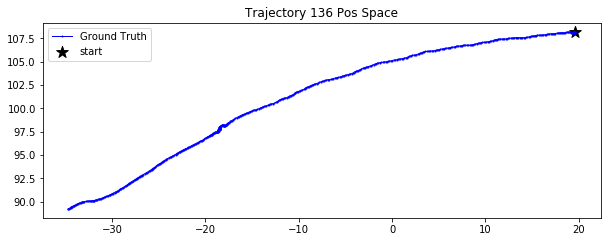

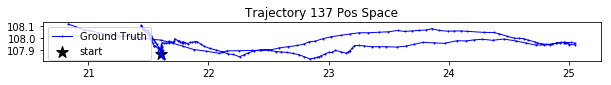

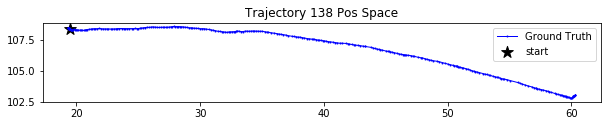

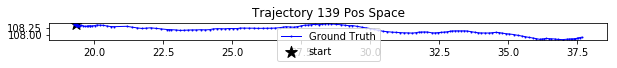

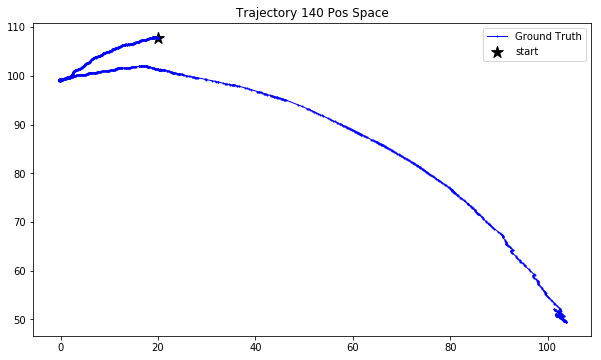

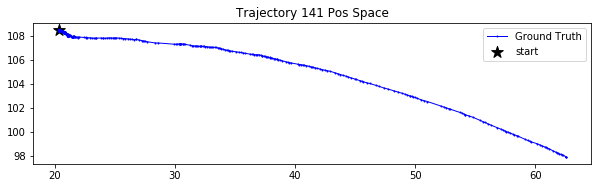

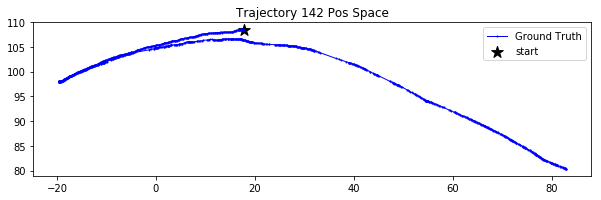

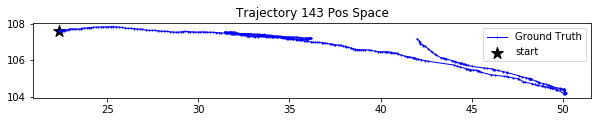

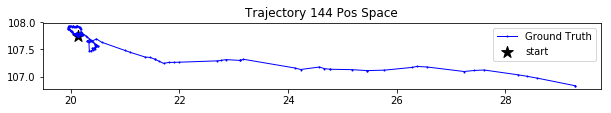

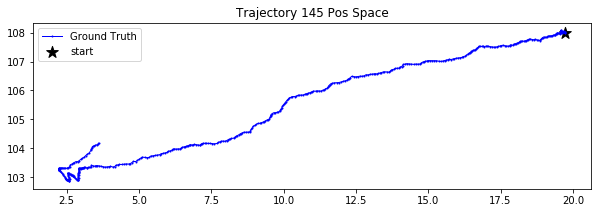

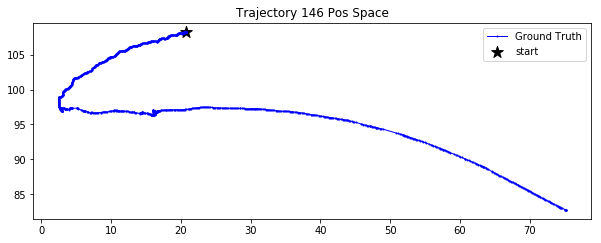

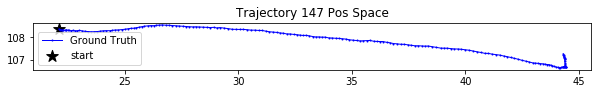

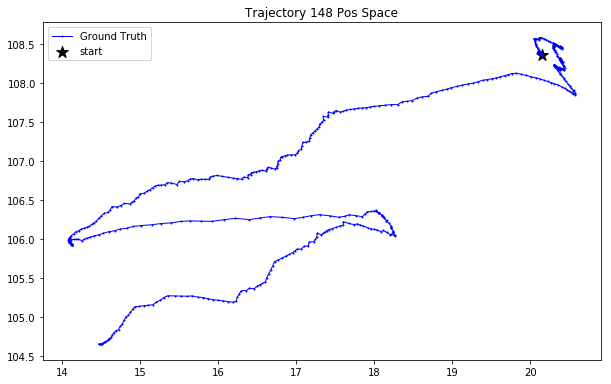

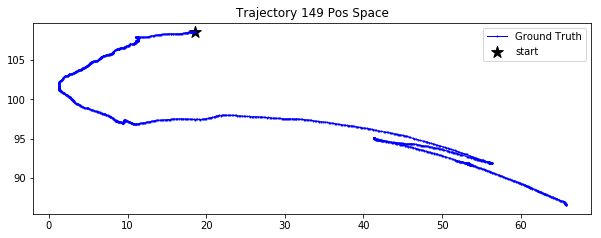

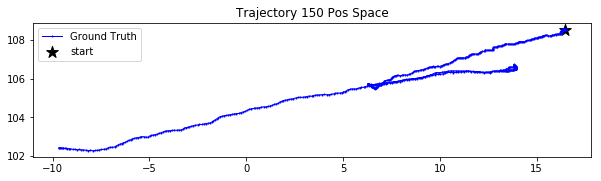

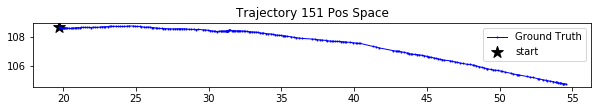

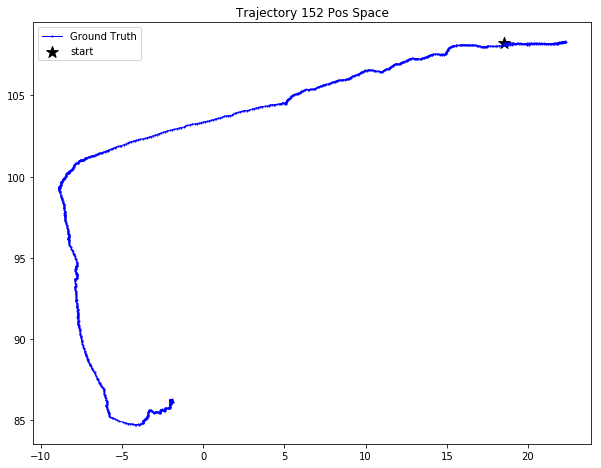

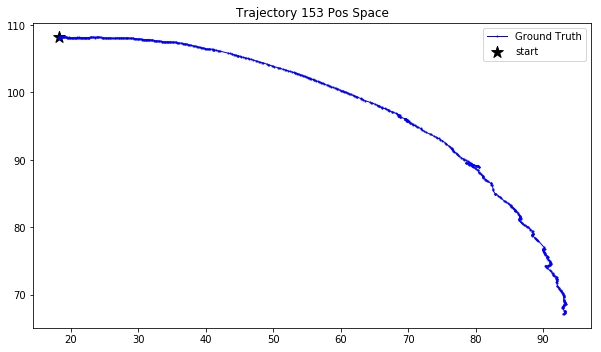

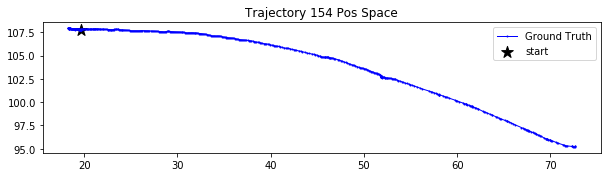

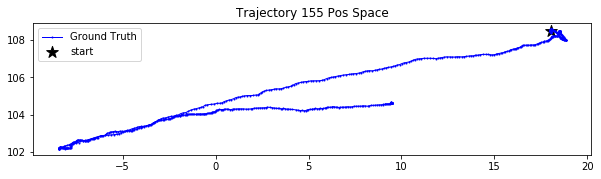

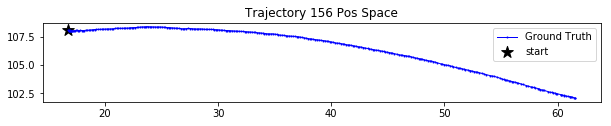

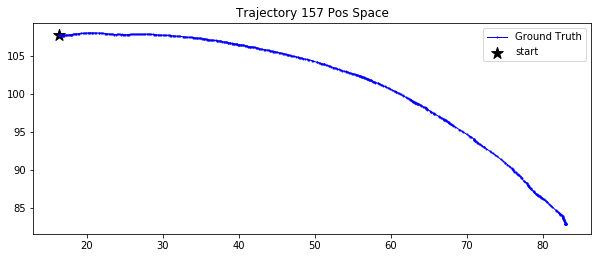

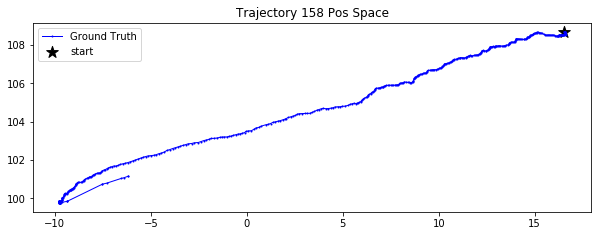

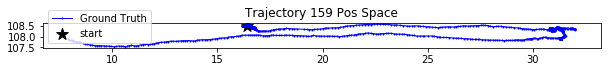

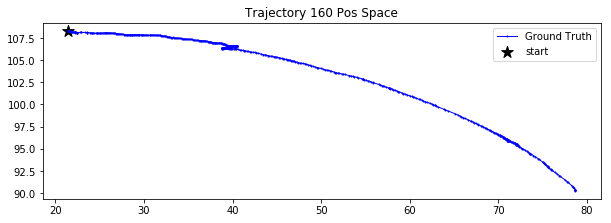

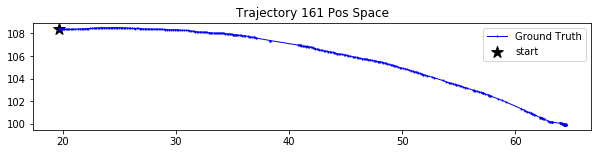

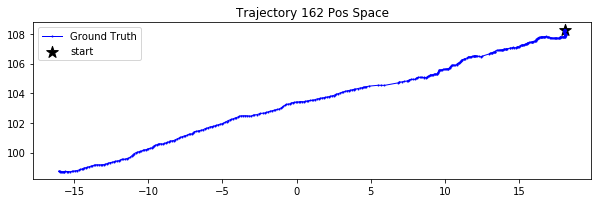

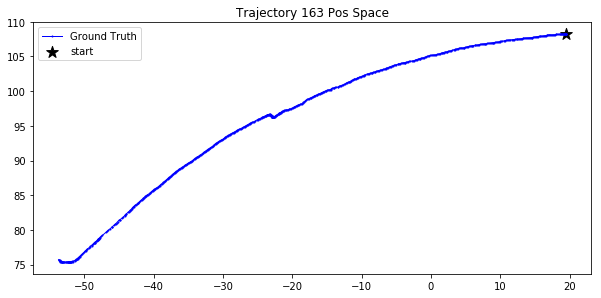

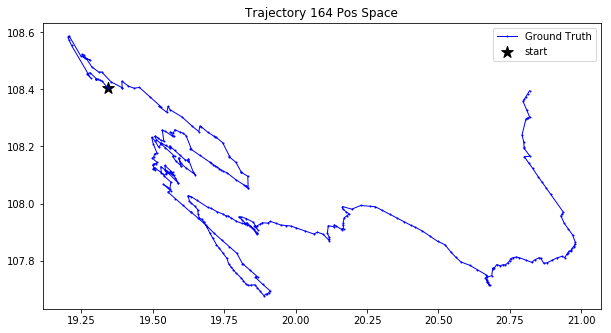

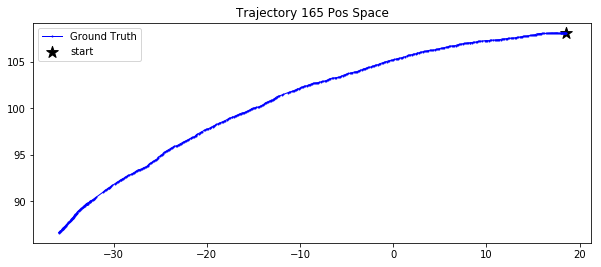

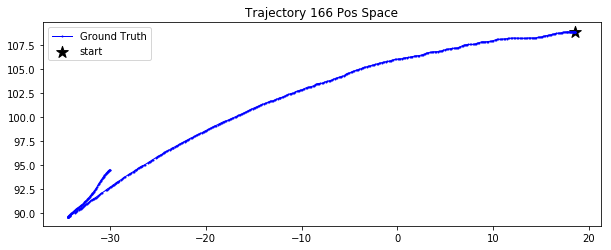

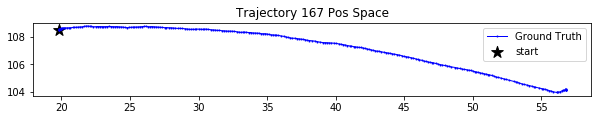

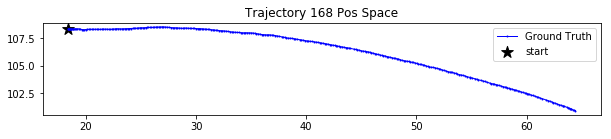

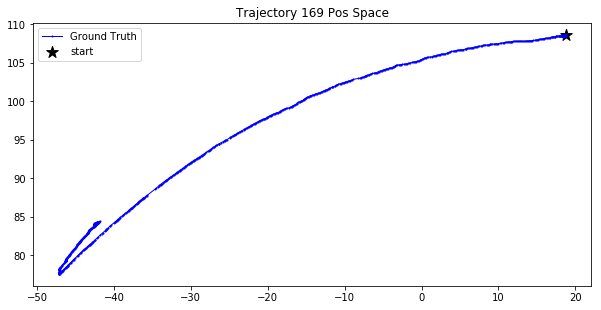

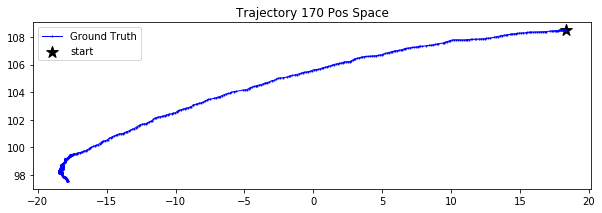

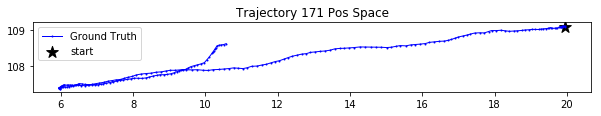

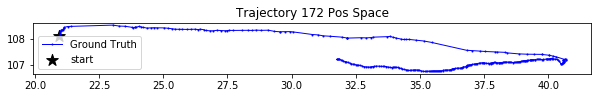

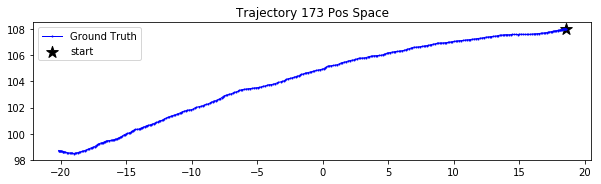

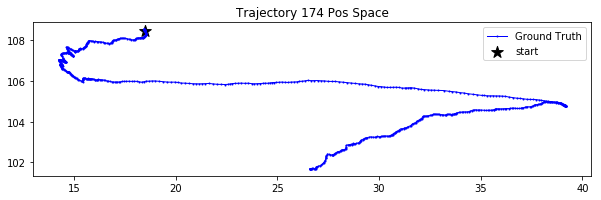

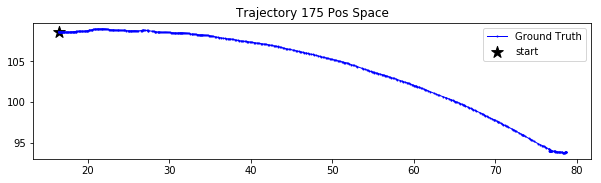

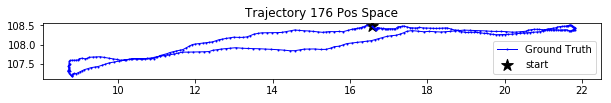

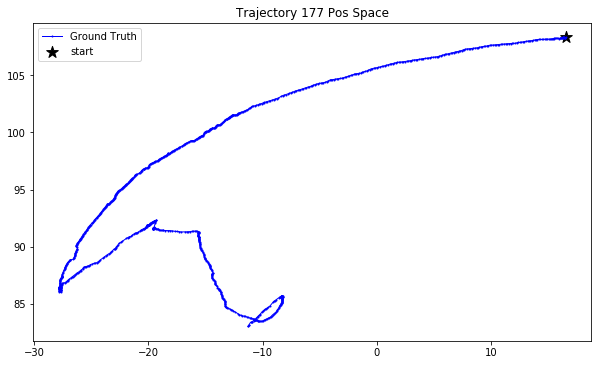

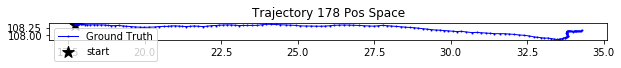

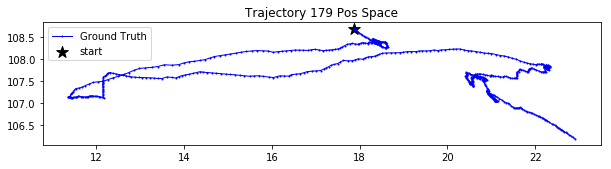

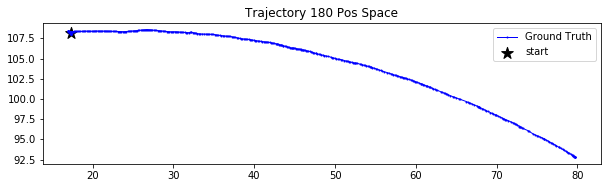

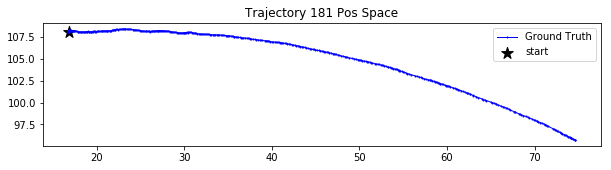

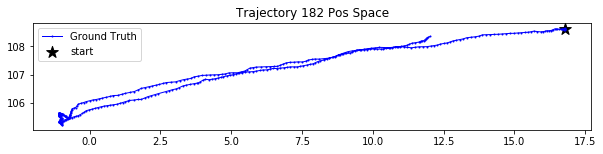

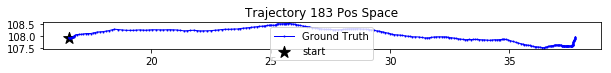

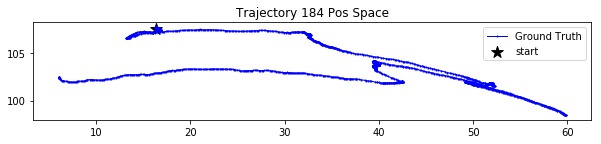

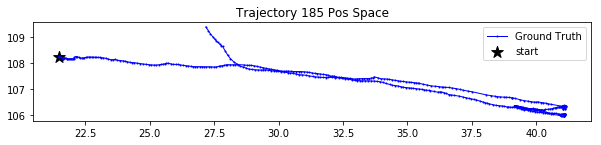

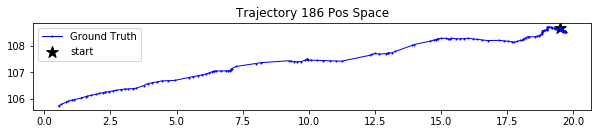

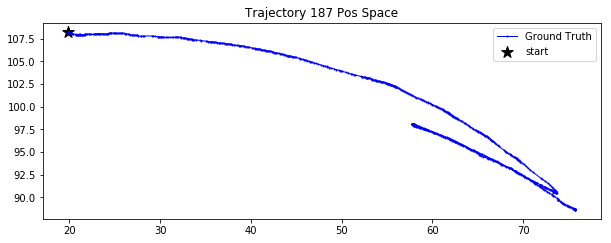

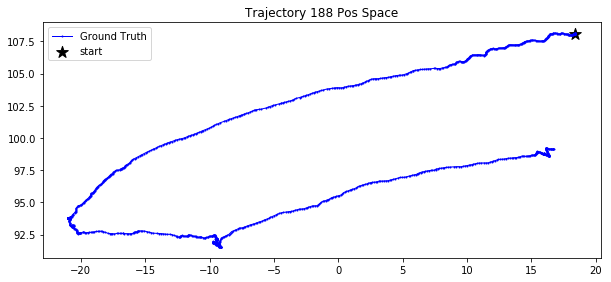

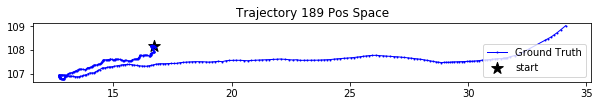

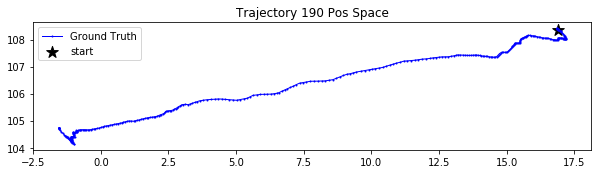

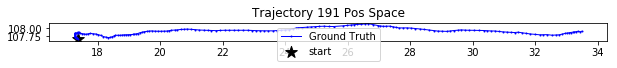

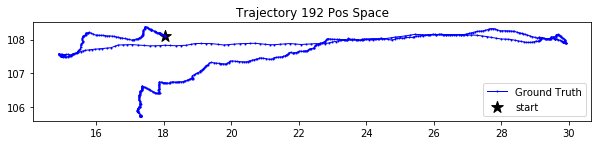

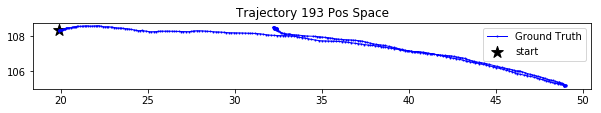

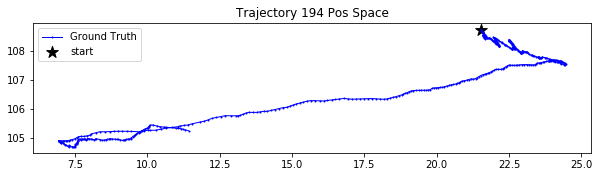

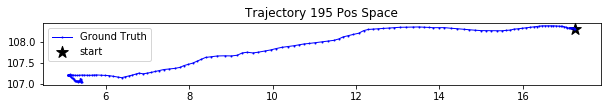

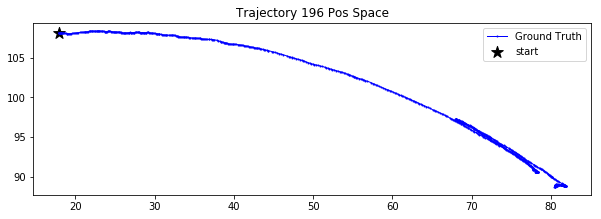

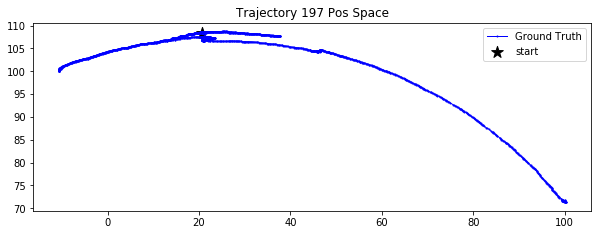

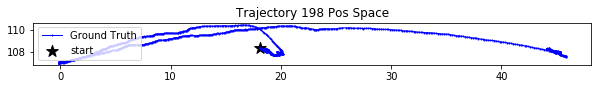

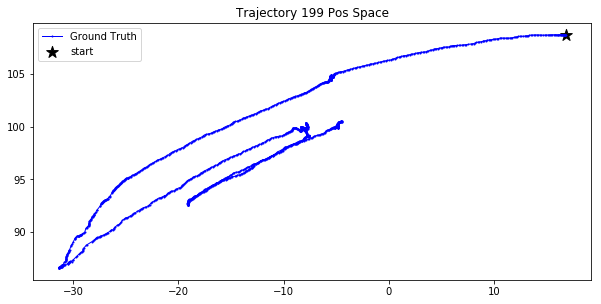

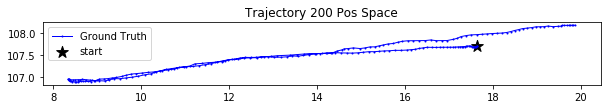

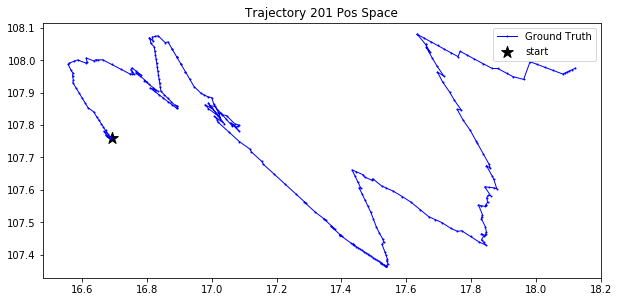

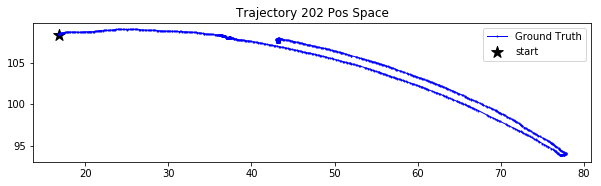

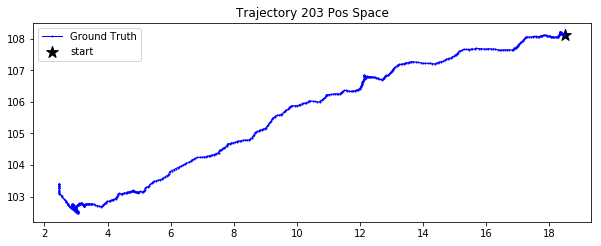

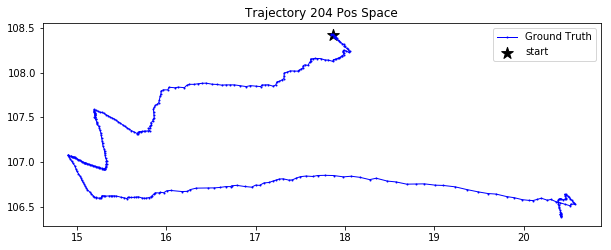

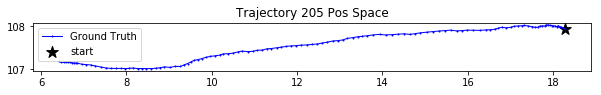

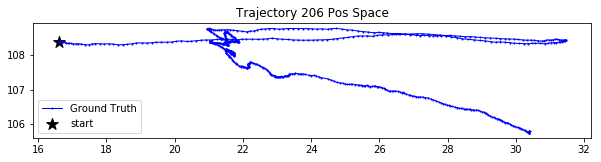

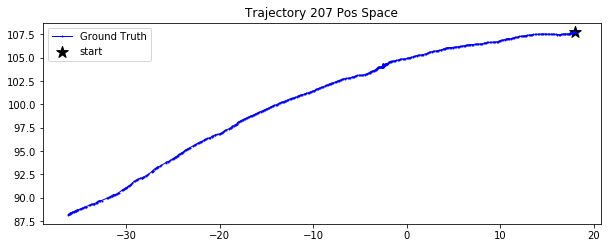

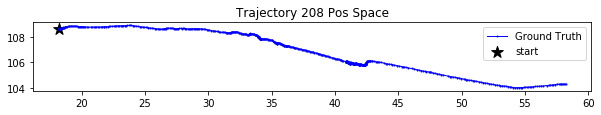

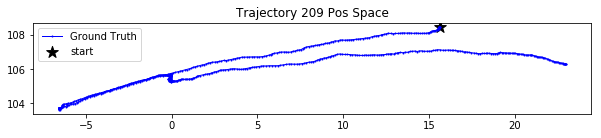

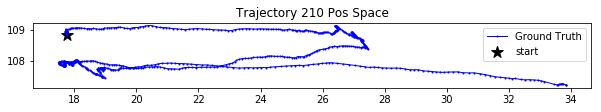

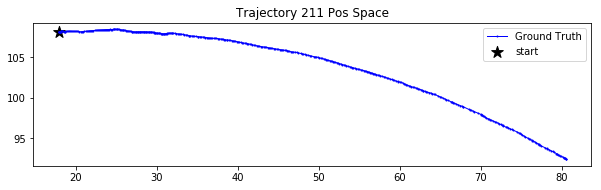

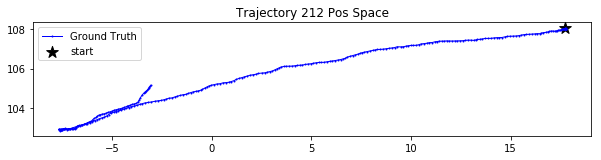

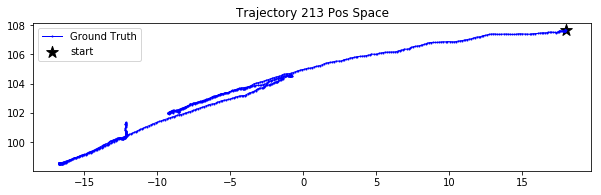

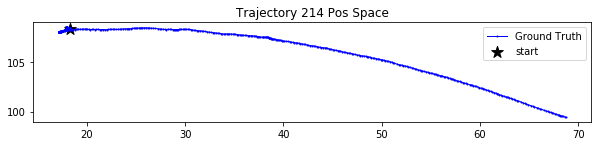

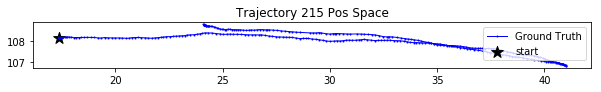

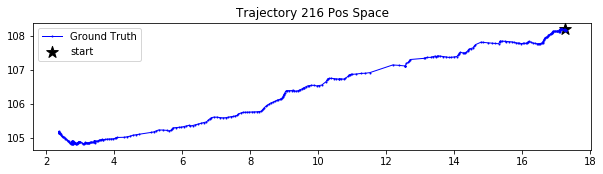

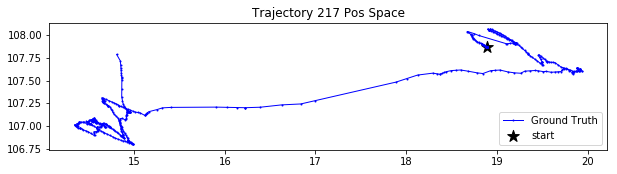

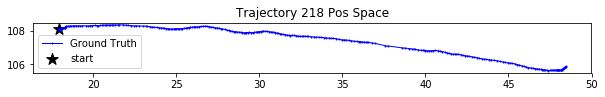

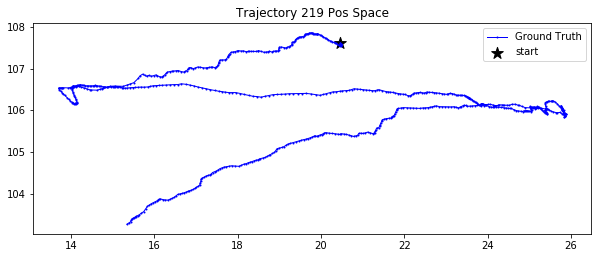

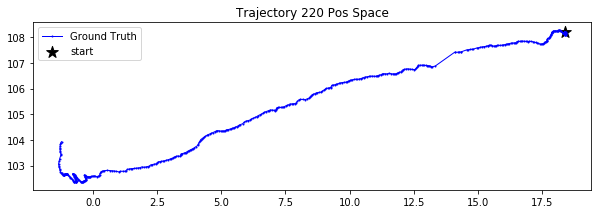

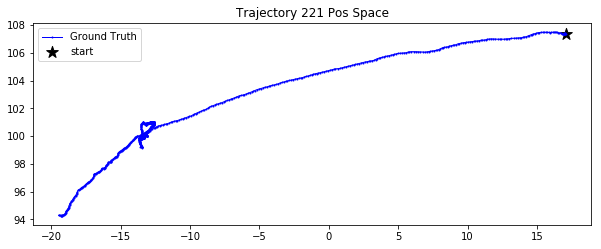

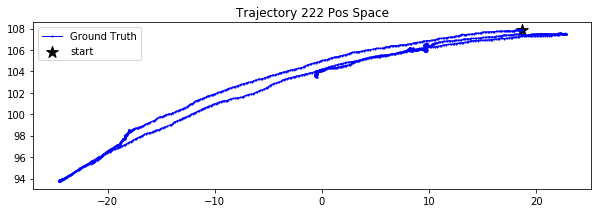

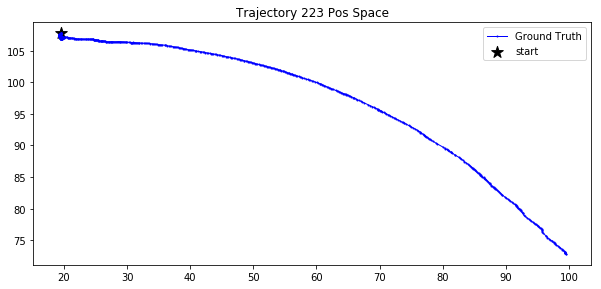

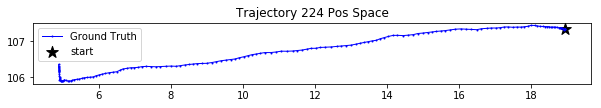

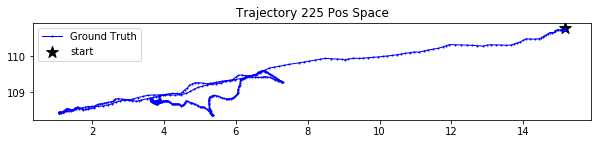

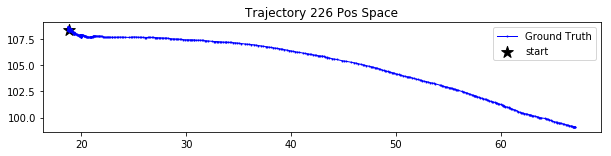

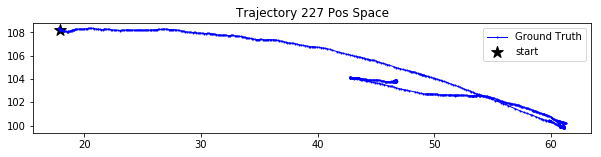

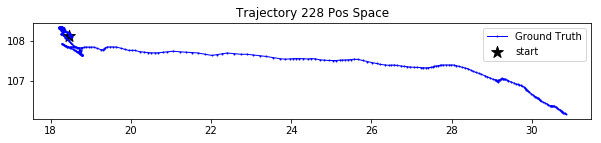

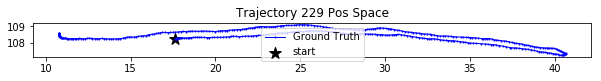

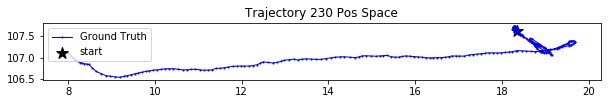

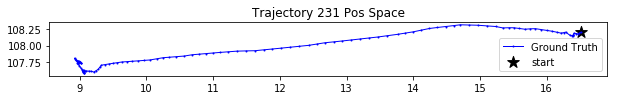

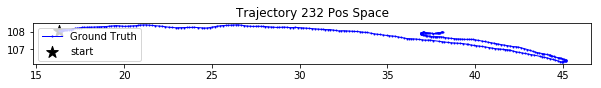

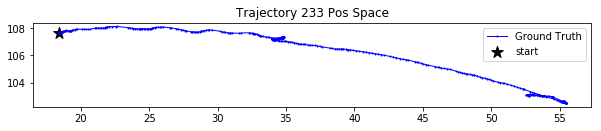

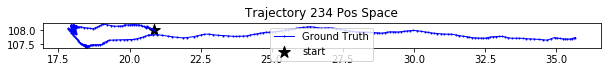

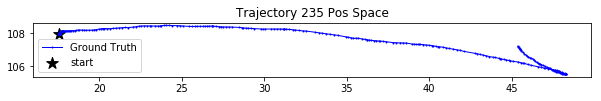

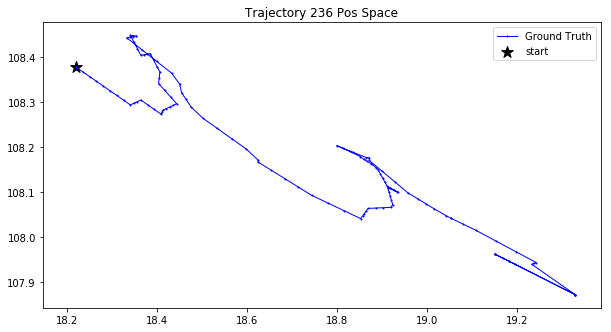

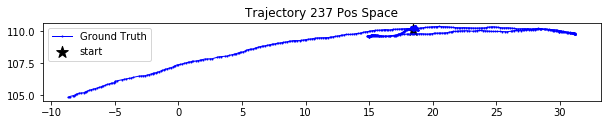

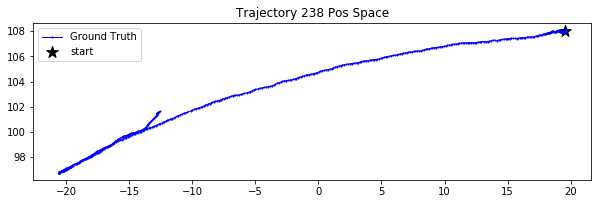

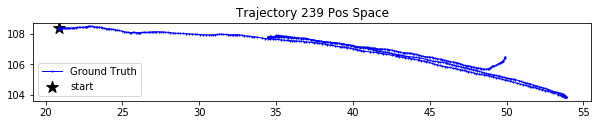

In [4]:
seed=0
nn_type = '2'
held_out = .1
lr = .0002
dropout_rate = .1
nodes=200
p4p=0
true_load=0
argv=['',0.0002,0.1,'2',0,0.1,200]
if len(argv)>3:
    lr=float(argv[1])
    held_out=float(argv[2])
    nn_type=argv[3]
    seed=int(argv[4])
    dropout_rate=float(argv[5])
    nodes=int(argv[6])
    if len(argv)>7:
        ep=int(argv[7])
        p4p=int(argv[8])
        true_load=int(argv[9])
pred_path = dm+'_'+train_mode+'_'+suffix+'pred_fig_f/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
if train_separate:
    test_ds_path=base_path+color+'_data/'+obj+'/test/test_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'
    train_ds_path=base_path+color+'_data/'+obj+'/train_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'
#Assume episodes are always separated
else:
    raise
with open(test_ds_path, 'rb') as pickle_file:
     test_ds_ls,test_ds_all_ls,state_dim,action_dim,test_traj_gt_ls,real_test_actions_ls = pickle.load(pickle_file)
with open(train_ds_path, 'rb') as pickle_file:
     train_ds_ls,train_ds_all_ls,state_dim,action_dim,train_traj_gt_ls,real_train_actions_ls = pickle.load(pickle_file)

#train_test_idx=[np.random.randint(len(train_ds_ls))]
train_test_idx=list(range(len(train_ds_ls)))
#train_test_idx=[52,55,69]
#train_test_idx=[101,208]
#train_test_idx=[]
#train_test_idx=list(range(20))
test_test_idx=['test 1','test 2']
#test_test_idx,test_ds_ls,test_ds_all_ls,test_traj_gt_ls,real_test_actions_ls=[],[],[],[],[]
if len(train_test_idx)!=0:   
    if len(train_test_idx)!=1:
        test_ds_ls+=[train_ds_ls[tt_idx] for tt_idx in train_test_idx]
        test_ds_all_ls+=[train_ds_all_ls[tt_idx] for tt_idx in train_test_idx]
        test_traj_gt_ls+=[train_traj_gt_ls[tt_idx] for tt_idx in train_test_idx]
        real_test_actions_ls+=[real_train_actions_ls[tt_idx] for tt_idx in train_test_idx]
    else:
        test_ds_ls.append(train_ds_ls[train_test_idx[0]])
        test_ds_all_ls.append(train_ds_all_ls[train_test_idx[0]])
        test_traj_gt_ls.append(train_traj_gt_ls[train_test_idx[0]])
        real_test_actions_ls.append(real_train_actions_ls[train_test_idx[0]])
    test_test_idx+=train_test_idx

task_ofs = state_dim + action_dim
test_ds = [torch.tensor(data, dtype=dtype) for data in test_ds_ls]
test_ds_all = [torch.tensor(data, dtype=dtype) for data in test_ds_all_ls]
real_test_actions=[torch.tensor(ac, dtype=dtype) for ac in real_test_actions_ls]
test_eps_len=[ep.shape[0] for ep in test_ds_ls]
print("Rolling out " + str(len(test_ds_ls)) + "test trajectories.")

dtype = torch.float
pred_fig_path = pred_path + 'traj_lr' + str(lr)+ '_' +'val' + str(held_out)+ '_' + 'seed' + str(seed) + '_nn_' + nn_type + '_dp_' + str(dropout_rate)+'_nodes_'+str(nodes)
init_states=[]
for i in range(len(test_ds_ls)):
    tt_idx=str(test_test_idx[i])
    gt_states = test_ds_all[i][:,:state_dim]
    real_actions = real_test_actions[i]
    valid_states_for_plot = np.vstack(test_traj_gt_ls[i])
    valid_states_for_plot = torch.tensor(valid_states_for_plot, dtype=dtype)
    #print(str(i-2)+':'+str(test_ds[i].shape[0]))
    fig = plt.figure()
    init_states.append(valid_states_for_plot[0, :4].numpy())
    plt.scatter(valid_states_for_plot[0, 0], valid_states_for_plot[0, 1], s=150, c='k', marker="*",label='start')
    plt.plot(valid_states_for_plot[:, 0], valid_states_for_plot[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
    plt.axis('scaled')
    plt.title('Trajectory '+tt_idx+ ' Pos Space')
    plt.legend()
    fig_loc=pred_fig_path +'_traj_'+tt_idx+'_pos.png'
    fig.set_size_inches(10, 10)
    #fig.savefig(fig_loc)
aaa=np.array(init_states)
print(aaa.shape)

In [3]:
mu=np.mean(aaa,axis=0)
sigma=np.std(aaa,axis=0)
print(mu,sigma)

[  -0.61181796  145.95969      80.55484    -102.35806   ] [2.7118096  0.52678216 8.356296   4.9099164 ]


In [5]:
np.random.normal(mu,sigma)

array([  -1.91233464,  146.47342819,   85.7284756 , -103.44243346])

In [8]:
max_load=[280,-280]
##-280 is min for right finger